<a href="https://colab.research.google.com/github/sujala111/Coursera_Capstone/blob/main/Capstone_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Neighborhoods of Toronto to open an Indian Restaurant**

### **DESCRIPTION OF THE PROBLEM AND DISCUSSION OF THE BACKGROUND:**
#### *Problem Statement: Exploring neighborhoods of Toronto to open Indian Restaurant*
Toronto, the capital of the province of Ontario. It is most populous Canadian city. One of the
most immigrant-friendly cities in North America with more than half of the entire Indian
Canadian Population residing in Toronto it is one of the best places to start an Indian
Restaurant.
In this project we go through the step by step process and analyze the neighborhoods in
Toronto to identify the most profitable area. As success of the restaurant depends on the
people and we already know that Toronto has greater number of Indians here, it is good
idea to start restaurant here. But we need to find the best place so that it yields more profit
to the owner.

#### **Target Audience**




*   Business people who wants to open an Indian restaurant in Toronto.
*   Indian crowd who wants to find neighborhoods with lots of options for Indian Restaurant.
*   Freelancer who wants to have their own restaurant as a side business.



### Importing Libraries

In [65]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [66]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')

#### Get information about neighborhoods present in Toronto

In [67]:
table_post = soup.find('table') # finding table in html file
fields = table_post.find_all('td') #finding td

postcode = [] # to append postal codes
borough = [] # to append borough
neighbourhood = [] # to append neighbourhood

for i in range(0, len(fields), 3):
    postcode.append(fields[i].text.strip()) 
    borough.append(fields[i+1].text.strip())
    neighbourhood.append(fields[i+2].text.strip())
        
df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
df.columns = ['Postalcode', 'Borough', 'Neighborhood']
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Ignoring the Borough that is not assigned


In [68]:
df = df[df['Borough']!='Not assigned']

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
 
for index,row in df.iterrows():
    if row['Neighborhood']=='Not assigned':
        row['Neighborhood']==row['Borough']

df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [69]:
df = df.groupby(['Borough', 'Postalcode'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postalcode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


#### Get all the geographical coordinates of the neighborhoods

In [70]:
geo = pd.read_csv('https://cocl.us/Geospatial_data')
geo = geo.rename(columns={'Postal Code': 'Postalcode'})
geo.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Adding geographical coordinates to the neighborhoods

In [71]:
toronto_DF = pd.merge(df,geo, on='Postalcode')
toronto_DF.head()

,Borough,Postalcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [72]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_DF['Borough'].unique()),
        toronto_DF.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Using geopy library to get latitude and longitude of Toronto

In [73]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [74]:
CLIENT_ID = 'your_client_id'
CLIENT_SECRET = 'your_client_secret'
VERSION = '20180605'

Retrieving the information about places present in the neighborhoods of Toronto. The API returns a JSON file and I'm turning it into a data-frame.

In [76]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()


In [77]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [78]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,CF Toronto Eaton Centre,Shopping Mall,43.654447,-79.380952
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


Explore the nearby venues

In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter

In [81]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
5,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
6,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
7,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
8,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place
9,Davisville North,43.712751,-79.390197,900 Mount Pleasant - Residents Gym,43.711671,-79.391767,Gym / Fitness Center


In [82]:
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


In [83]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 273 uniques categories.


There are 273 categories in which Indian Restaurant is one of them.We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.



In [84]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,

In [85]:
print (toronto_venues['Venue Category'].value_counts())


Coffee Shop                        192
Café                                93
Restaurant                          67
Park                                51
Pizza Place                         50
Hotel                               44
Sandwich Place                      43
Bakery                              41
Japanese Restaurant                 41
Italian Restaurant                  40
Bar                                 34
Gym                                 34
Clothing Store                      33
Sushi Restaurant                    29
Grocery Store                       26
American Restaurant                 25
Pub                                 25
Fast Food Restaurant                24
Breakfast Spot                      23
Bank                                23
Seafood Restaurant                  22
Thai Restaurant                     22
Pharmacy                            21
Bookstore                           19
Beer Bar                            19
Gastropub                

Using folium library to draw map of toronto using coordinate data

In [86]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Relationship between neighborhood and Indian Restaurant

we'll extract the Neighborhood and Indian Restaurant column from above toronto dataframe

In [87]:
toronto_part = toronto_grouped[['Neighborhood', 'Indian Restaurant']]
toronto_part

,Neighborhood,Indian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455
5,Berczy Park,0.000000
6,"Birch Cliff, Cliffside West",0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000
8,"Business reply mail Processing Centre, South C...",0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000


In [88]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.030303
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.000000
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.000000
7,Central Toronto,M5P,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0.000000
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.052632
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.000000


This plot helps in identifying the boroughs with densely populated Indian Restaurants

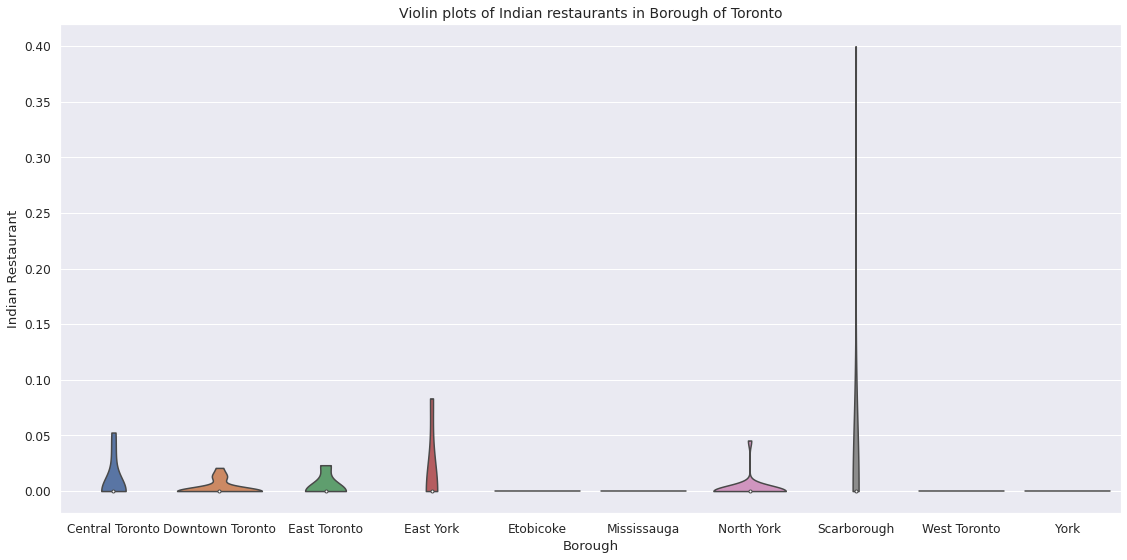

In [89]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Indian Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Indian restaurants in Borough of Toronto', fontsize=14)
plt.show()

Visualizing neighborhood with Indian Restaurant

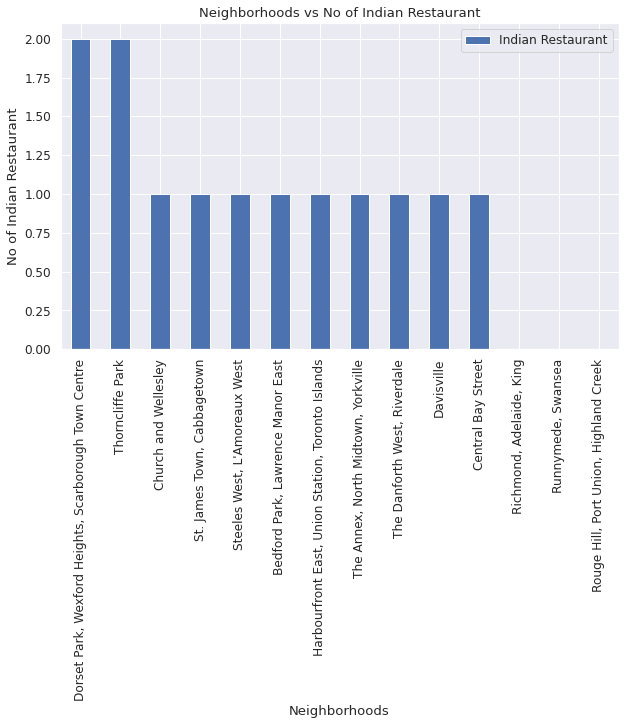

In [90]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by ='Indian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Indian Restaurant")
plt.title("Neighborhoods vs No of Indian Restaurant")
plt.show()

#### Scraping the distribution of population 
Another factor that can help us in deciding which neighborhood would be best option to open a restaurant is, the distribution of population based on the ethnic diversity for each neighborhood. As this helps us in identifying the neighborhoods which are densely populated with Indian crowd since that neighborhood would be an ideal place to open an Indian restaurant.

In [91]:
!pip install wikipedia
import wikipedia as wp
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [92]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[12]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[13]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [94]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[14]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[15]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Relation between neighborhood and Indian population

In [96]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above dataframe we can pickout the neighborhoods with highest Indian population percentage by using the below given method.

In [97]:
#Filtering the riding with Indian ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'East Indian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'East Indian')]
pop_indian_df = pd.DataFrame(temp).reset_index()
pop_indian_df.drop('index',axis=1,inplace=True)

pop_indian_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
3,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN,NaN,NaN
5,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0,NaN,NaN
7,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN,NaN,NaN
8,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
pop_indian_df.shape

(10, 20)

In [99]:
#retaining only Indian ethnic percentage & the neighborhood name 
columns_list = pop_indian_df.columns.tolist()
#columns_list
pop_indian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]
#print(columns_list)

for i in range(0,pop_indian_df.shape[0]):
    for j in columns_list:
        #print(j)
        if pop_indian_df.at[i, j] == 'East Indian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_indian_DF_with_percent = pop_indian_DF_with_percent.append({'Riding':pop_indian_df.at[i, 'Riding'], 'Population':pop_indian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_indian_df.at[i, j], 'Percentage': pop_indian_df.at[i, percent_col]},ignore_index=True)

pop_indian_DF_with_percent   

,Ethnicity,Percentage,Population,Riding
0,East Indian,7.3,109060.0,Don Valley North
1,East Indian,9.2,107725.0,Humber River-Black Creek
2,East Indian,10.6,93170.0,Don Valley East
3,East Indian,12.2,110450.0,Scarborough Centre
4,East Indian,8.2,108295.0,Scarborough Southwest
5,East Indian,7.4,104225.0,Scarborough-Agincourt
6,East Indian,16.7,101445.0,Scarborough-Rouge Park
7,East Indian,18.0,101115.0,Scarborough-Guildwood
8,East Indian,11.8,97610.0,Scarborough North
9,East Indian,22.2,116960.0,Etobicoke North


In [100]:
pop_indian_DF_with_percent['Indian Population'] = (pop_indian_DF_with_percent['Percentage'] * pop_indian_DF_with_percent['Population'])/100
pop_indian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_indian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_indian_DF_with_percent

,Riding,Indian Population
0,Don Valley North,7961.380
1,Humber River-Black Creek,9910.700
2,Don Valley East,9876.020
3,Scarborough Centre,13474.900
4,Scarborough Southwest,8880.190
5,Scarborough-Agincourt,7712.650
6,Scarborough-Rouge Park,16941.315
7,Scarborough-Guildwood,18200.700
8,Scarborough North,11517.980
9,Etobicoke North,25965.120


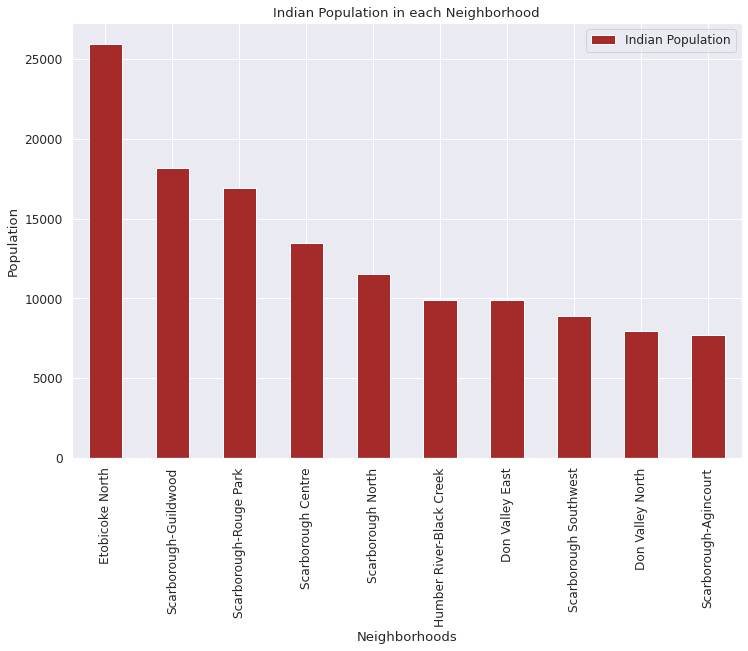

In [101]:
bar_graph = pop_indian_DF_with_percent.sort_values(by='Indian Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Indian Population',figsize=(12,8), color='brown')
plt.title("Indian Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

The above visualization helps in identifying the highly populated indian neighborhoods.Once we identify those neighborhoods it helps us in deciding where to place the new Indian restaurant. Indian restaurant placed in an densely populated Indian neighborhood is more likely to get more Indian customers than a restaurant placed in a neighborhood with less or no Indian population.

#### Realtionship between Indian population and Indian restaurant

In [102]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_indian_DF_with_percent['Riding'].tolist()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list

['Don Valley North',
 'Humber River-Black Creek',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Etobicoke North']

In [103]:
Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wp.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df


,Riding,Neighborhoods
0,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un..."
2,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...
4,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
5,Scarborough-Agincourt,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
6,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
7,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."
8,Scarborough North (electoral district),"Agincourt (east of Midland Avenue), Milliken ..."
9,Etobicoke North,"The Elms, Humberwood, Kingsview Village, This..."


In [104]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_indian_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop


,Indian Population,Neighborhoods
0,7961.380,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,9910.700,"Humber Summit, Humbermede, Humberlea, York Un..."
2,9876.020,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,8880.190,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
4,7712.650,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
5,16941.315,"Morningside Heights, Rouge, Port Union, West ..."
6,18200.700,"Guildwood, West Hill (west of Morningside Ave..."
7,25965.120,"The Elms, Humberwood, Kingsview Village, This..."


In [105]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,Indian Population,Neighborhood
0,7961.380,Henry Farm
1,9910.700,Humber Summit
2,9876.020,Flemingdon Park
3,8880.190,Birch Cliff
4,7712.650,Steeles
5,16941.315,Morningside Heights
6,18200.700,Guildwood
7,25965.120,The Elms
8,7961.380,Bayview Village
9,9910.700,Humbermede


In [106]:
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Indian Restaurant,Neighborhood
0,0.000000,Agincourt
1,0.000000,Alderwood
2,0.000000,Bathurst Manor
3,0.000000,Bayview Village
4,0.045455,Bedford Park
5,0.000000,Berczy Park
6,0.000000,Birch Cliff
7,0.000000,Brockton
8,0.000000,Business reply mail Processing Centre
9,0.000000,CN Tower


This dataframe helps in identifying the relation between Indian population, Indian Restaurant and Neighborhoods

In [107]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent

,Indian Population,Neighborhood,Indian Restaurant
0,7961.380,Henry Farm,0.0
1,8880.190,Oakridge,0.0
2,16941.315,Rouge,0.0
3,16941.315,Port Union,0.0
4,18200.700,Morningside,0.0
5,25965.120,Thistletown,0.0
6,8880.190,Clairlea,0.0
7,16941.315,Highland Creek,0.0


#### Predictive modeling

#### Clustering Neighborhoods of Toronto
First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset.

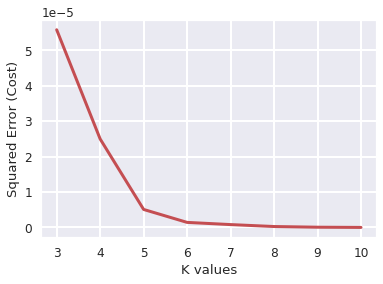

In [108]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [109]:
kclusters = 6

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 3, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 2, 0, 3, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 2, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [110]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_DF
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,3.0,0.030303
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.000000
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.000000
5,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,5.0,0.013333
6,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.000000
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,3.0,0.020833
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.000000
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,5.0,0.014706


Let's see the clusters visually on the map

In [111]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### Examining the clusters

Cluster 0 contains all the neighborhoods which has least number of Indian restaurants. It is shown in red color in the map

In [112]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
3,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
4,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0
6,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,0.0,0.0
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,0.0,0.0
10,Downtown Toronto,M5W,Stn A PO Boxes,43.646435,-79.374846,0.0,0.0
11,Downtown Toronto,M6G,Christie,43.669542,-79.422564,0.0,0.0
12,East Toronto,M4E,The Beaches,43.676357,-79.293031,0.0,0.0
13,East Toronto,M4M,Studio District,43.659526,-79.340923,0.0,0.0


In [113]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]


,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant


In [114]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]


,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant


Cluster 3 contains the neighborhoods which is medium populated with Indian restaurants. It is shown in purple color in the map

In [115]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]


,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
2,Central Toronto,M4S,Davisville,43.704324,-79.388790,3.0,0.030303
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,3.0,0.020833


Cluster 4 contains all the neighborhoods which is densely populated with Indian restaurants. It is shown in blue color in the map.

In [116]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]


,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
16,East York,M4H,Thorncliffe Park,43.705369,-79.349372,4.0,0.083333


Cluster 5 contains all the neighborhoods which is sparsely populated with Indian restaurants. It is shown in blue color in the map.

In [117]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]


,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
5,Downtown Toronto,M4Y,Church and Wellesley,43.665860,-79.383160,5.0,0.013333
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,5.0,0.014706


In [118]:
toronto_merged['Borough'].value_counts()

North York          13
Downtown Toronto     8
Central Toronto      4
Scarborough          4
East York            3
York                 3
East Toronto         2
Mississauga          1
Etobicoke            1
Name: Borough, dtype: int64

#### Results

* Among all the boroughs, we identified that only Central Toronto, Downtown Tronto, East Toronto, East York, North York & Scarborough boroughs have high amount of Indian restaurants with the help of Violin plots between Number of Indian restaurants in Borough of Toronto.

* In all the ridings, Scarborough-Guildwood, Scarborough-Rouge Park, Scarborough Centre, Scarborough North, Humber River-Black Creek, Don Valley East, Scarborough Southwest, Don Valley North & Scarborough-Agincourt are the densely populated with Indian crowd ridings.

* With the help of CLusters we can say that Downtown Toronto, Central Toronto, East York are already densely populated with Indian restaurants. So it is better idea to leave those boroughs out and consider only Scarborough, East Toronto & North York for the new restaurant's location.

* It is a good idea to open a new Indian restaurant in Scarborough borough since it has high number of Indian population which gives a higher number of customers possibility and lower competition since very less Indian restaurants in the neighborhoods.